# Urea Irradiation Experiments

## Import modules

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import ipympl
%matplotlib ipympl
import re
import pandas as pd
import glob

from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib import colormaps
from matplotlib.gridspec import GridSpec
from datetime import timedelta
from collections import defaultdict
from scipy.signal import savgol_filter
from scipy.stats import linregress
from scipy.interpolate import interp1d

## Extinction Coefficient calculation
The slope of the graph when plotting absorbance against concentration is the extinction coefficient according to Beer's law:<br>

Absorbance = concentration x ext_coeff x path_length (1cm)

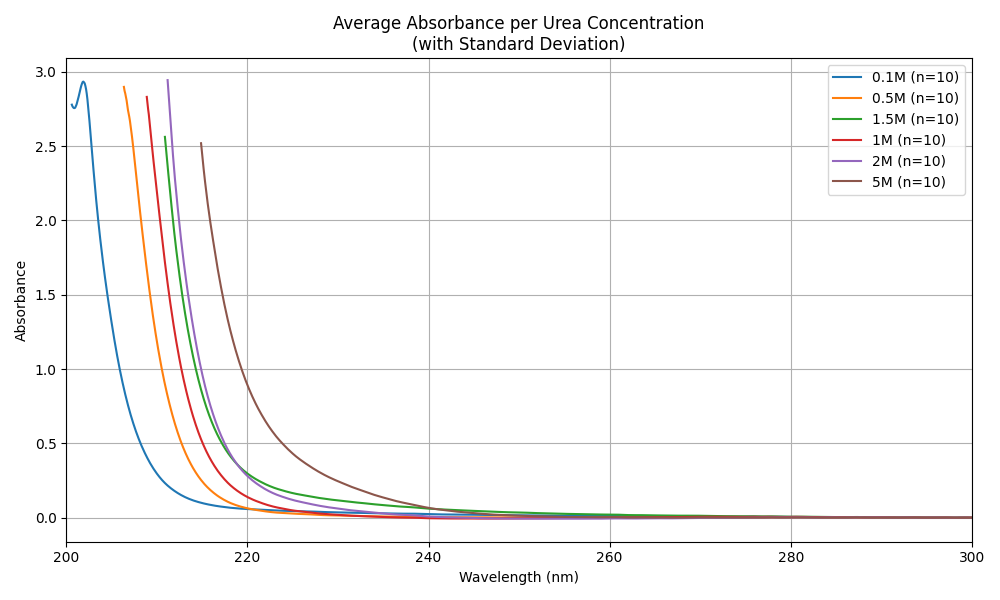

Gradient (slope) of absorbance vs concentration at 220 nm: 0.1414 Abs/M
Intercept: 0.0225
R-squared: 0.8769


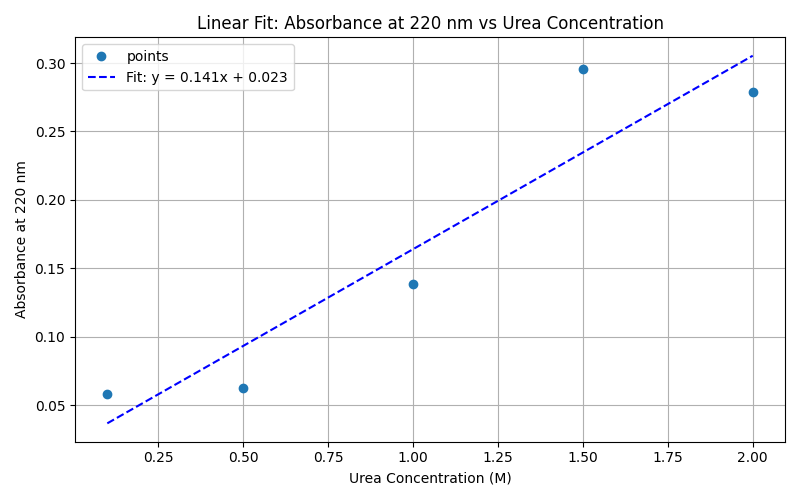

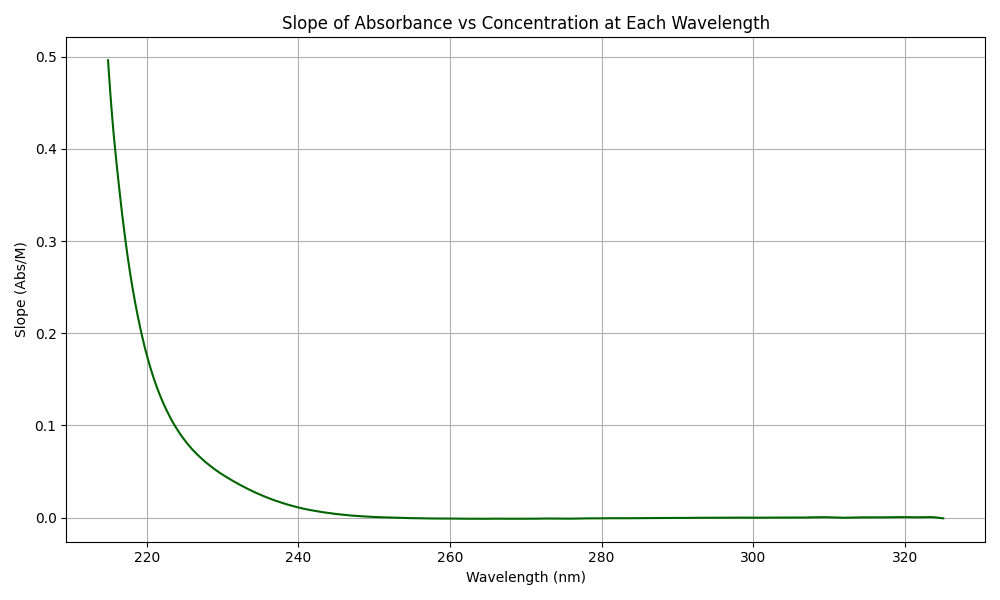

Slope data saved to 'extinction_coeff_calibration_1.csv'


In [5]:
# --- Parameters ---
skip = 40
data_path = './D2_lamp_results/20250702_urea_calibration/*.txt'
savgol_window = 21  # Must be odd
savgol_poly = 3

# --- Load Background and Reference ---
for file in glob.glob(data_path):
    if 'background' in file:
        x, I_background = np.loadtxt(file, skiprows=skip, usecols=(0,1), unpack=True)
    elif 'reference' in file:
        x, I_ref = np.loadtxt(file, skiprows=skip, usecols=(0,1), unpack=True)

# --- Initialize Absorbance Storage ---
absorbance_data = defaultdict(list)

# Define expected concentrations in filename
concentrations = ['0.1M', '0.5M', '1M', '1.5M', '2M', '5M']

# --- Load and Process Sample Files ---
for file in glob.glob(data_path):
    if 'background' in file or 'reference' in file or 'Background' in file:
        continue
    
    for conc in concentrations:
        if conc in file:
            x, I = np.loadtxt(file, skiprows=skip, usecols=(0,1), unpack=True)
            with np.errstate(divide='ignore', invalid='ignore'):  # handle log10 warnings
                absorbance = -np.log10((I - I_background) / (I_ref - I_background))
            absorbance_data[conc].append(absorbance)
            break  # stop after finding the concentration

# --- Plotting Average + Std Dev with Smoothing ---
plt.figure(figsize=(10,6))
norm_wavelength = 300
norm_idx = np.argmin(np.abs(x - norm_wavelength))
target_wavelength = 250
target_idx = np.argmin(np.abs(x - target_wavelength))

abs_data = {'0.1M' :[], '0.5M':[], '1M':[], '1.5M':[], '2M':[], '5M': []}

for conc in sorted(absorbance_data.keys()):
    stack = np.vstack(absorbance_data[conc])         # shape: (n_repeats, n_points)
    mean_abs = np.mean(stack, axis=0)
    std_abs = np.std(stack, axis=0)
    
    # Smooth the mean and std
    smoothed_mean = savgol_filter(mean_abs, savgol_window, savgol_poly)
    smoothed_std = savgol_filter(std_abs, savgol_window, savgol_poly)
    
    shift = 0 - smoothed_mean[norm_idx]
    smoothed_mean_shift = smoothed_mean+shift
    
    abs_data[conc].append(smoothed_mean_shift)
    # Plot with shaded error band
    plt.plot(x, smoothed_mean_shift, label=f'{conc} (n={len(stack)})')
    # plt.fill_between(x, smoothed_mean - smoothed_std, smoothed_mean + smoothed_std, alpha=0.2)

# plot for different concentrations
plt.xlabel('Wavelength (nm)')
plt.xlim(200,300)
plt.ylabel('Absorbance')
plt.title('Average Absorbance per Urea Concentration\n(with Standard Deviation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# print(abs_data)
# --- Extract Absorbance at 220 nm and Plot vs. Concentration ---
target_wavelength = 220
target_idx = np.argmin(np.abs(x - target_wavelength))

# Convert concentrations to numerical values for plotting
conc_values = []
abs_values = []

for conc in sorted(abs_data.keys(), key=lambda s: float(s.replace('M',''))):
    if conc =='5M':
        continue
    smoothed_abs = abs_data[conc][0]  # Get the smoothed and normalized absorbance
    absorbance_at_220 = smoothed_abs[target_idx]
    
    conc_float = float(conc.replace('M', ''))  # e.g., '0.5M' → 0.5
    conc_values.append(conc_float)
    abs_values.append(absorbance_at_220)

# Fit linear regression
slope, intercept, r_value, p_value, std_err = linregress(conc_values, abs_values)

# Print the gradient
print(f"Gradient (slope) of absorbance vs concentration at 220 nm: {slope:.4f} Abs/M")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")

# Plot with regression line
x_fit = np.linspace(min(conc_values), max(conc_values), 100)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(8,5))
plt.plot(conc_values, abs_values, 'o', label='points')
plt.plot(x_fit, y_fit, 'b--', label=f'Fit: y = {slope:.3f}x + {intercept:.3f}')
plt.xlabel('Urea Concentration (M)')
plt.ylabel('Absorbance at 220 nm')
plt.title('Linear Fit: Absorbance at 220 nm vs Urea Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Convert concentration strings to floats and sort
sorted_concs = sorted(abs_data.keys(), key=lambda s: float(s.replace('M','')))
conc_floats = np.array([float(c.replace('M','')) for c in sorted_concs])

# Create a 2D array: shape (n_concentrations, n_wavelengths)
abs_matrix = np.vstack([abs_data[c][0] for c in sorted_concs])  # shape: (n_concs, n_wavelengths)

# Store slopes per wavelength
slopes = []

for i in range(len(x)):
    y_vals = abs_matrix[:, i]  # absorbance at this wavelength across concentrations
    slope, intercept, r_value, p_value, std_err = linregress(conc_floats, y_vals)
    slopes.append(slope)

# Convert to numpy array for convenience
slopes = np.array(slopes)

# --- Plot slope vs wavelength ---
plt.figure(figsize=(10,6))
plt.plot(x, slopes, color='darkgreen')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Slope (Abs/M)')
plt.title('Slope of Absorbance vs Concentration at Each Wavelength')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save slopes to file ---
output_filename = 'extinction_coeff_calibration_1.csv'
with open(output_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Wavelength (nm)', 'Extinction coefficient'])
    for wl, slope in zip(x, slopes):
        writer.writerow([wl, slope])

print(f"Slope data saved to '{output_filename}'")

Background file: ./D2_lamp_results/20250704_urea_calibration_2\20250704_background_MAYP1162681_11-02-04-812.txt
Reference file: ./D2_lamp_results/20250704_urea_calibration_2\20250704_reference_h2O_MAYP1162681_11-03-26-778.txt


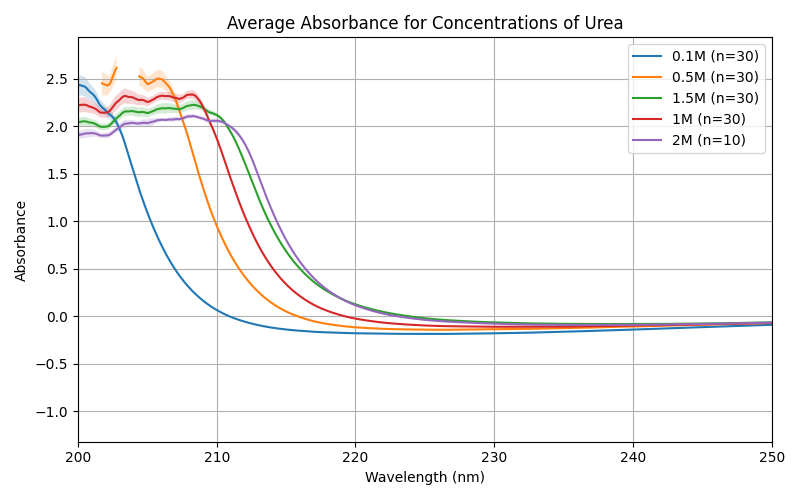

Gradient (slope) of absorbance vs concentration at 220 nm: 0.1716 Abs/M
Intercept: -0.1931
R-squared: 0.9323


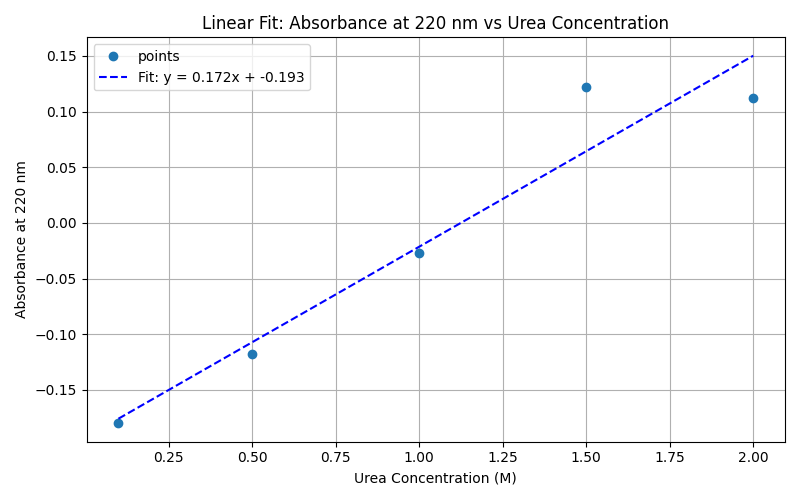

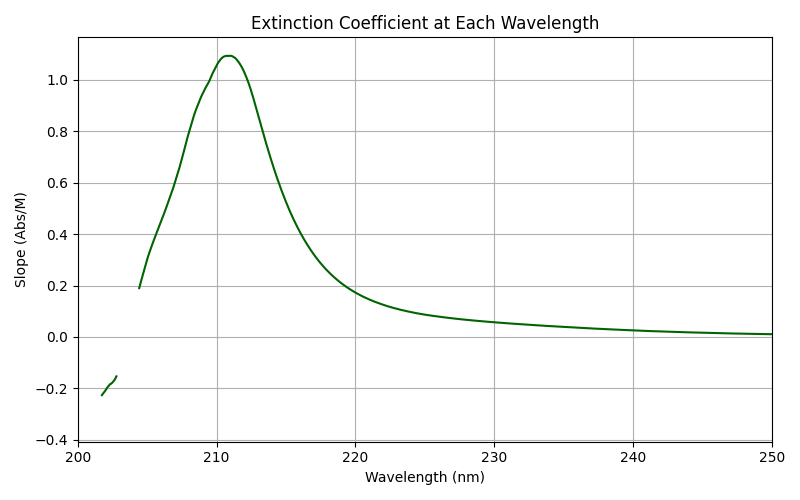

Slope data saved to 'extinction_coeff_calibration_2.csv'


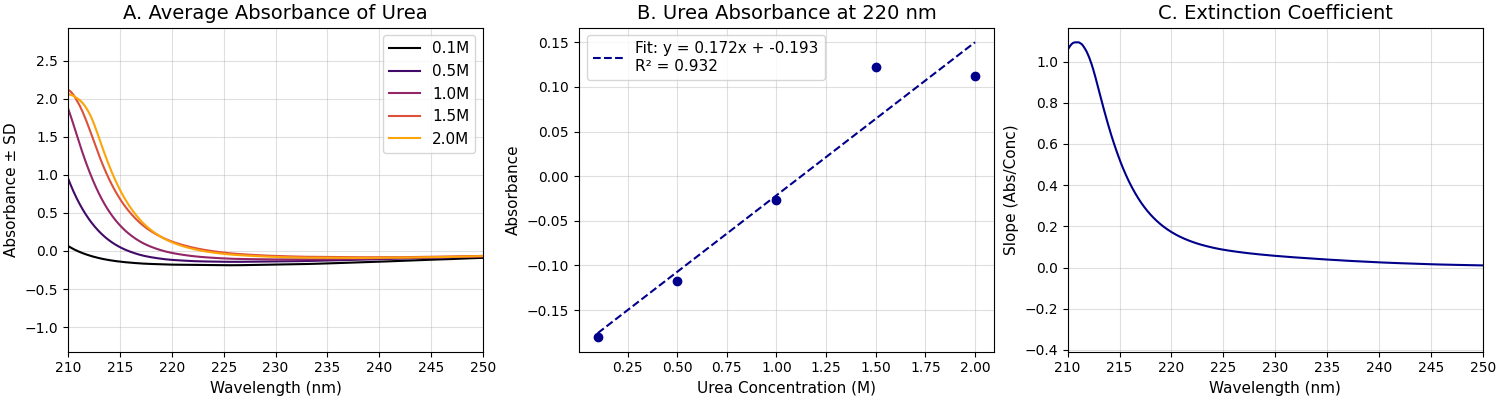

In [64]:
# --- Parameters ---
skip = 40
data_path = './D2_lamp_results/20250704_urea_calibration_2/*.txt'
savgol_window = 21  # Must be odd
savgol_poly = 3

# --- Load Background and Reference ---
for file in glob.glob(data_path):
    if 'background_MAYP' in file:
        x, I_background = np.loadtxt(file, skiprows=skip, usecols=(0,1), unpack=True)
        print('Background file:', file)
    elif 'reference' in file:
        x, I_ref = np.loadtxt(file, skiprows=skip, usecols=(0,1), unpack=True)
        print('Reference file:', file)

# Initialize Absorbance Storage
absorbance_data = defaultdict(list)

# Define expected concentrations in filename
concentrations = ['0.1M', '0.5M', '1M', '1.5M', '2M']

# Load and Process Sample Files 
for file in glob.glob(data_path):
    if 'background' in file or 'reference' in file:
        continue
    
    for conc in concentrations:
        if conc in file:
            x, I = np.loadtxt(file, skiprows=skip, usecols=(0,1), unpack=True)
            with np.errstate(divide='ignore', invalid='ignore'):  # handle log10 warnings
                absorbance = -np.log10((I - I_background) / (I_ref - I_background))
            absorbance_data[conc].append(absorbance)
            break  # stop after finding the concentration
         
        
plt.figure(figsize=(8,5))
norm_wavelength = 300
norm_idx = np.argmin(np.abs(x - norm_wavelength))

abs_data = {'0.1M' :[], '0.5M':[], '1M':[], '1.5M':[], '2M':[], '5M': []}

for conc in sorted(absorbance_data.keys()):
    stack = np.vstack(absorbance_data[conc])
    mean_abs = np.mean(stack, axis=0)
    std_abs = np.std(stack, axis=0)
    
    # Smooth the mean and std
    smoothed_mean = savgol_filter(mean_abs, savgol_window, savgol_poly)
    smoothed_std = savgol_filter(std_abs, savgol_window, savgol_poly)
    
    shift = 0 - smoothed_mean[norm_idx]
    smoothed_mean_shift = smoothed_mean+shift
    
    abs_data[conc].append(smoothed_mean_shift)
    # plot and include std
    plt.plot(x, smoothed_mean_shift, label=f'{conc} (n={len(stack)})')
    plt.fill_between(x, smoothed_mean+shift - smoothed_std, smoothed_mean+shift + smoothed_std, alpha=0.2)

# plot for different concentrations
plt.xlabel('Wavelength (nm)')
plt.xlim(200,250)
plt.ylabel('Absorbance')
plt.title('Average Absorbance for Concentrations of Urea')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# find absorbance at target wavelength
target_wavelength = 220
target_idx = np.argmin(np.abs(x - target_wavelength))

# values for each concentration
conc_values = [0.1, 0.5, 1, 1.5, 2]
abs_values = []

for conc in sorted(abs_data.keys(), key=lambda s: float(s.replace('M',''))):
    if conc =='5M':
        continue
    smoothed_abs = abs_data[conc][0]  # smoothed and normalized abs
    absorbance_at_220 = smoothed_abs[target_idx]
    abs_values.append(absorbance_at_220)

# Fit linear regression
slope, intercept, r_value, p_value, std_err = linregress(conc_values, abs_values)

# Print the gradient
print(f"Gradient (slope) of absorbance vs concentration at 220 nm: {slope:.4f} Abs/M")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")

# Plot with regression line
x_fit = np.linspace(min(conc_values), max(conc_values), 100)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(8,5))
plt.plot(conc_values, abs_values, 'o', label='points')
plt.plot(x_fit, y_fit, 'b--', label=f'Fit: y = {slope:.3f}x + {intercept:.3f}')
plt.xlabel('Urea Concentration (M)')
plt.ylabel('Absorbance at 220 nm')
plt.title('Linear Fit: Absorbance at 220 nm vs Urea Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Convert concentration strings to floats and sort
sorted_concs=['0.1M', '0.5M', '1M', '1.5M', '2M']
conc_floats = np.array([float(c.replace('M','')) for c in sorted_concs])

# Create a 2D array: shape (n_concentrations, n_wavelengths)
abs_matrix = np.vstack([abs_data[c][0] for c in sorted_concs])  # shape: (n_concs, n_wavelengths)

# Store slopes per wavelength
slopes = []

for i in range(len(x)):
    y_vals = abs_matrix[:, i]  # absorbance at this wavelength across concentrations
    slope, intercept, r_value, p_value, std_err = linregress(conc_floats, y_vals)
    slopes.append(slope)

# Convert to numpy array for convenience
slopes = np.array(slopes)

# Plot slope vs wavelength
plt.figure(figsize=(8,5))
plt.plot(x, slopes, color='darkgreen')
plt.xlim(200,250)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Slope (Abs/M)')
plt.title('Extinction Coefficient at Each Wavelength')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save slopes to file
output_filename = 'extinction_coeff_calibration_2.csv'
with open(output_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Wavelength (nm)', 'Extinction coefficient'])
    for wl, slope in zip(x, slopes):
        writer.writerow([wl, slope])

print(f"Slope data saved to '{output_filename}'")


##################################################
#### Plotting a panel of three for the report ###
##################################################
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
# fontsizes
title_fs = 14
label_fs = 11
legend_fs = 11
# rename conc labels for consistenc
def pretty_label(conc):
    val = float(conc.replace('M',''))
    return f"{val:.1f}M"
# colormap and color selection
cmap = colormaps['inferno']
fracs = [0,0.2,0.4,0.6,0.8]
color_map = {conc: cmap(frac) for conc, frac in zip(sorted_concs, fracs)}

# Panel A: avg + std dev
ax = axes[0]
for conc in sorted(absorbance_data.keys(), key=lambda s: float(s.replace('M',''))):
    stack = np.vstack(absorbance_data[conc])
    mean_abs = np.mean(stack, axis=0)
    std_abs = np.std(stack, axis=0)
    sm_mean = savgol_filter(mean_abs, savgol_window, savgol_poly)
    sm_std  = savgol_filter(std_abs, savgol_window, savgol_poly)
    shift = -sm_mean[norm_idx]
    sm_mean_shift = sm_mean + shift
    
    c = color_map[conc]
    ax.plot(x, sm_mean_shift, label=pretty_label(conc), color=c)
    ax.fill_between(
        x,
        sm_mean_shift - sm_std,
        sm_mean_shift + sm_std,
        color=c,
        alpha=0.2,
        edgecolor=None
    )

ax.set_xlim(210, 250)
ax.set_xlabel('Wavelength (nm)', fontsize=label_fs)
ax.set_ylabel('Absorbance ± SD', fontsize=label_fs)
ax.set_title('A. Average Absorbance of Urea', fontsize=title_fs)
ax.legend(fontsize=legend_fs)
ax.grid(alpha=0.4)

# Panel B: Abs@220 vs [Urea]
ax = axes[1]
conc_values = []
abs_values  = []
for conc in sorted_concs: 
    conc_values.append(float(conc.replace('M','')))
    abs_values.append(abs_data[conc][0][target_idx])

slope, intercept, r_value, _, _ = linregress(conc_values, abs_values)
x_fit = np.linspace(min(conc_values), max(conc_values), 100)
y_fit = slope*x_fit + intercept

ax.plot(conc_values, abs_values, 'o', color='darkblue')
ax.plot(x_fit, y_fit, '--', color='darkblue',label=(
        f'Fit: y = {slope:.3f}x + {intercept:.3f}\n'
        f'R² = {r_value**2:.3f}'))
ax.set_xlabel('Urea Concentration (M)', fontsize=label_fs)
ax.set_ylabel('Absorbance', fontsize=label_fs)
ax.set_title('B. Urea Absorbance at 220 nm', fontsize=title_fs)
ax.legend(fontsize=legend_fs)
ax.grid(alpha=0.4)

# Panel C: Extinction Coefficient vs λ
ax = axes[2]
ax.plot(x, slopes, color='darkblue')
ax.set_xlim(210, 250)
ax.set_xlabel('Wavelength (nm)', fontsize=label_fs)
ax.set_ylabel('Slope (Abs/Conc)', fontsize=label_fs)
ax.set_title('C. Extinction Coefficient', fontsize=title_fs)
ax.grid(alpha=0.4)

plt.show()

## Absorbances and gradients over time for different concentrations

### 2M Concentration

Loaded background: ./D2_lamp_results/20250630_urea_2M\20250630_background_MAYP1162681_16-16-59-695.txt
Loaded reference: ./D2_lamp_results/20250630_urea_2M\20250630_reference_H2O_MAYP1162681_16-18-42-687.txt


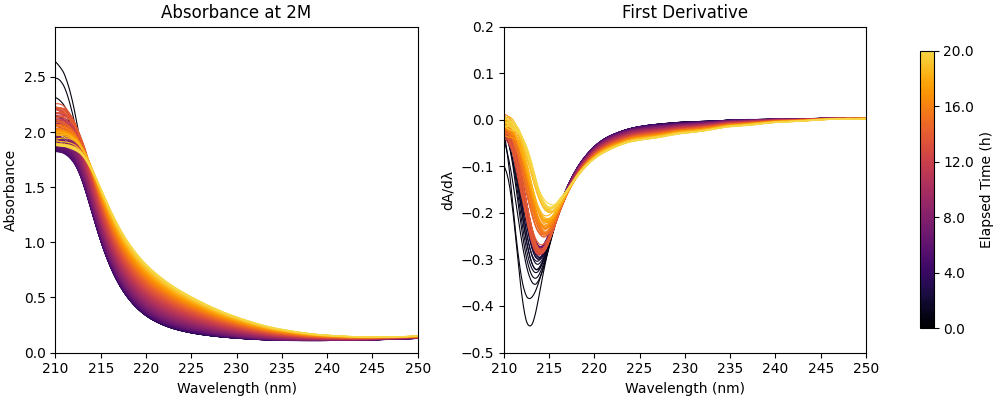

Extinction coefficient at 215 nm: 0.5250630092162083
Fit: concentration = -0.0409 * time + 2.0340
R² = 0.8948


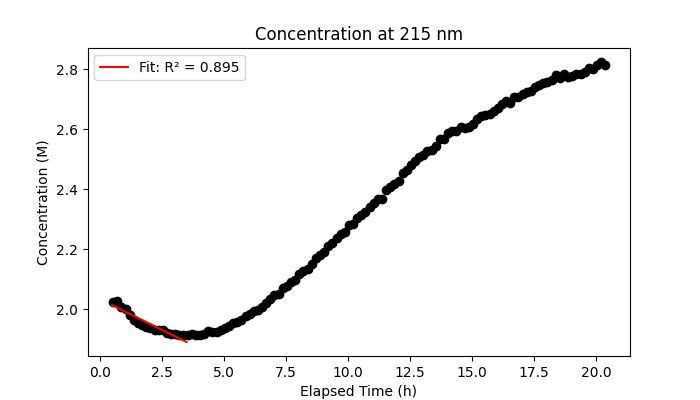

In [62]:
# Parameters
skip = 40
exp_folder = './D2_lamp_results/20250630_urea_2M'
norm_idx = 320 # normalisation wavelength
starting_hour = 16  # experiment start hour

def extract_elapsed_seconds(filename):
    time_str = os.path.basename(filename).split('_')[-1].replace('.txt', '')
    h, m, s, ms = map(int, time_str.split('-'))
    total_sec = h * 3600 + m * 60 + s + ms / 1000.0
    offset_sec = starting_hour * 3600
    elapsed = total_sec - offset_sec
    if elapsed < 0: # after midnight
        elapsed += 24 * 3600
    return elapsed

# load experiment files
all_txt = glob.glob(os.path.join(exp_folder, '*.txt'))
exp_files = [f for f in all_txt if all(tag not in f for tag in ('background', 'reference', 'standard'))]
exp_files.sort(key=lambda f: extract_elapsed_seconds(f))

# Compute elapsed time
elapsed_sec = [extract_elapsed_seconds(f) for f in exp_files]
elapsed_hr = [t / 3600.0 for t in elapsed_sec]

# Colormap 
original_cmap = colormaps['inferno']
# modify colourmap to remove light colours
mod_cmap = original_cmap(np.linspace(0.0, 0.9, 256))
cmap = LinearSegmentedColormap.from_list("inferno_trunc", mod_cmap, N=256)
norm = Normalize(vmin=0, vmax=20)

# Load background and reference
I_background = I_ref = None
for file in all_txt:
    if 'background' in file:
        x, I_background = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
        print('Loaded background:', file)
    elif 'reference' in file:
        x, I_ref = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
        print('Loaded reference:', file)

# Prepare absorbance traces
abs_traces = []
for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_traces.append(abs_trace)

# --- Plot absorbance and its derivative ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, constrained_layout=True)

for abs_trace, t_hr in zip(abs_traces, elapsed_hr):
    # smoothing
    window_length = min(51, len(abs_trace) // 2 * 2 + 1)
    abs_smooth = savgol_filter(abs_trace, window_length=window_length, polyorder=3)
    dA = np.gradient(abs_smooth, x)
    dA_smooth = savgol_filter(dA, window_length=window_length, polyorder=3)

    color = cmap(norm(t_hr))
    ax1.plot(x, abs_smooth, color=color, lw=0.8)
    ax2.plot(x, dA_smooth, color=color, lw=0.8)

# # sanity check start/end spectra
# # start
# start_file = exp_files[0]
# x, I0 = np.loadtxt(start_file, skiprows=skip, usecols=(0, 1), unpack=True)
# abs0 = -np.log10((I0 - I_background) / (I_ref - I_background))
# ax1.plot(x, abs0, 'k-', label='Start')
# # end
# end_file = exp_files[-1]
# x, Iend = np.loadtxt(end_file, skiprows=skip, usecols=(0, 1), unpack=True)
# absE = -np.log10((Iend - I_background) / (I_ref - I_background))
# ax1.plot(x, absE, 'r-', label='End')
# ax1.legend()

# Colorbar from 0 to 20 hrs
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='vertical', location='right', shrink=0.85)
cbar.set_label('Elapsed Time (h)')
ticks = np.linspace(0, 20, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.1f}" for t in ticks])

# Labels and limits
ax1.set_xlim(210, 250)
ax1.set_ylim(0)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Absorbance')
ax1.set_title('Absorbance at 2M')
# ax1.axvline(213)

ax2.set_xlim(210, 250)
ax2.set_ylim(-0.5,0.2)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('dA/dλ')
ax2.set_title('First Derivative')

plt.show()

###################################
### Concentration plot
###################################

ext_data = pd.read_csv('./extinction_coeff_calibration_2.csv')
interp = interp1d(ext_data['Wavelength (nm)'], ext_data['Extinction coefficient'],
                  kind='linear', fill_value='extrapolate')
target_wavelength = 215
epsilon = float(interp(target_wavelength))
pathlength = 1.0  # cm
print(f'Extinction coefficient at {target_wavelength} nm: {epsilon}')

# index for target wavelength
idx = (np.abs(x - target_wavelength)).argmin()
concentrations = [trace[idx] / (epsilon * pathlength) for trace in abs_traces]

# convert elapsed time to numpy array
elapsed_hr = np.array(elapsed_hr)

# select points between 0 and 3 hours
min_hr = 0.5
max_hr = 3.5
mask = (elapsed_hr >= min_hr) & (elapsed_hr <= max_hr)
t_fit = elapsed_hr[mask]
c_fit = np.array(concentrations)[mask]
# linear regression (degree 1 polynomial)
slope, intercept = np.polyfit(t_fit, c_fit, 1)
print(f'Fit: concentration = {slope:.4f} * time + {intercept:.4f}')

# build fit line over 0–3 h
t_line = np.linspace(min_hr, max_hr, 50)
c_line = slope * t_line + intercept
# Fit and get r-value:
res = linregress(t_fit, c_fit)
slope, intercept, r_value = res.slope, res.intercept, res.rvalue
# R² is just r_value squared:
r2 = r_value**2
print(f'R² = {r2:.4f}')

plt.figure(figsize=(7, 4))
plt.plot(elapsed_hr, concentrations, 'o', lw=1, color='black')
plt.plot(t_line, slope*t_line + intercept, '-', color='red', label=f'Fit: R² = {r2:.3f}')
plt.legend()
plt.xlabel('Elapsed Time (h)')
plt.ylabel('Concentration (M)')
plt.title(f'Concentration at {target_wavelength} nm')
plt.show()

### 0.1 M Concentration

Loaded background: ./D2_lamp_results/20250703_urea_0.1M\20250703_background_MAYP1162681_11-57-55-545.txt
Loaded reference: ./D2_lamp_results/20250703_urea_0.1M\20250703_reference_H2O_MAYP1162681_11-59-20-513.txt


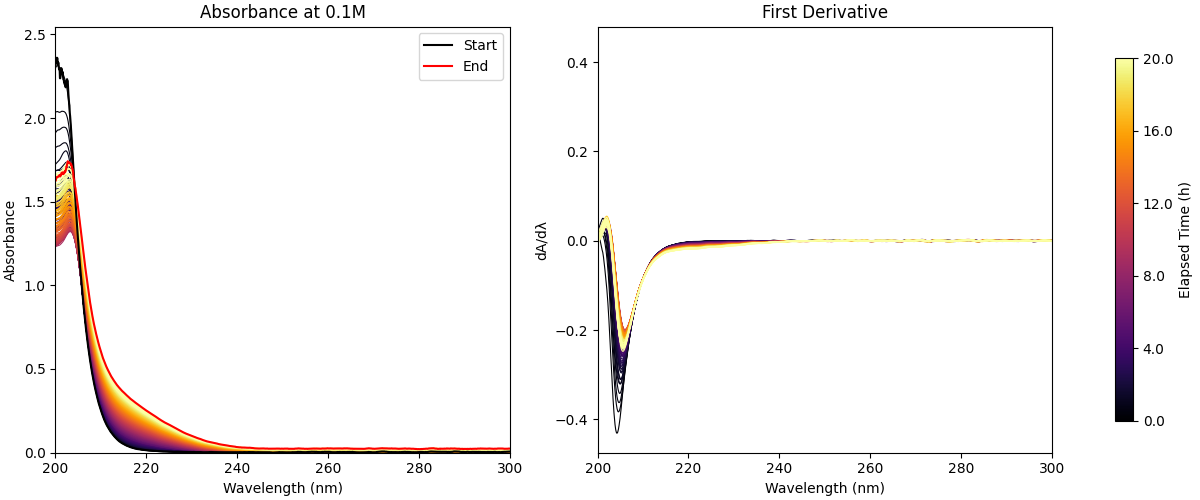

Extinction coefficient at 220 nm: 0.17254317746071357


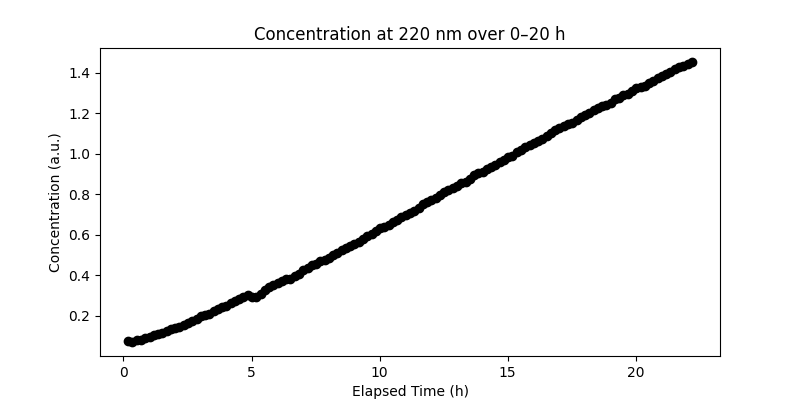

In [11]:
skip = 40
exp_folder = './D2_lamp_results/20250703_urea_0.1M'
norm_idx = 320
starting_hour = 12 # start hour of experiment

def extract_elapsed_seconds(filename):
    """
    Convert timestamp in filename to seconds elapsed since starting_hour,
    wrapping past midnight as needed.
    """
    time_str = os.path.basename(filename).split('_')[-1].replace('.txt', '')
    h, m, s, ms = map(int, time_str.split('-'))
    total_sec = h * 3600 + m * 60 + s + ms / 1000.0
    offset_sec = starting_hour * 3600
    elapsed = total_sec - offset_sec
    if elapsed < 0:
        # crossed midnight
        elapsed += 24 * 3600
    return elapsed

# Gather and sort experiment files (exclude background/reference/standard)
all_txt = glob.glob(os.path.join(exp_folder, '*.txt'))
exp_files = [f for f in all_txt if all(tag not in f for tag in ('background', 'reference', 'standard'))]
exp_files.sort(key=lambda f: extract_elapsed_seconds(f))

# Compute elapsed times in seconds and hours
elapsed_sec = [extract_elapsed_seconds(f) for f in exp_files]
elapsed_hr = [t / 3600.0 for t in elapsed_sec]

# Colormap from 0 to 20 hours
cmap = colormaps['inferno']
norm = Normalize(vmin=0, vmax=20)

# Load background and reference
I_background = I_ref = None
for file in all_txt:
    if 'background' in file:
        x, I_background = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
        print('Loaded background:', file)
    elif 'reference' in file:
        x, I_ref = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
        print('Loaded reference:', file)

# Prepare absorbance traces
abs_traces = []
for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_traces.append(abs_trace)

# --- Plot absorbance and its derivative ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, constrained_layout=True)

for abs_trace, t_hr in zip(abs_traces, elapsed_hr):
    # smoothing
    window_length = min(51, len(abs_trace) // 2 * 2 + 1)
    abs_smooth = savgol_filter(abs_trace, window_length=window_length, polyorder=3)
    dA = np.gradient(abs_smooth, x)
    dA_smooth = savgol_filter(dA, window_length=window_length, polyorder=3)

    color = cmap(norm(t_hr))
    ax1.plot(x, abs_smooth, color=color, lw=0.8)
    ax2.plot(x, dA_smooth, color=color, lw=0.8)

# Sanity-check start/end spectra
# start
start_file = exp_files[0]
x, I0 = np.loadtxt(start_file, skiprows=skip, usecols=(0, 1), unpack=True)
abs0 = -np.log10((I0 - I_background) / (I_ref - I_background))
ax1.plot(x, abs0, 'k-', label='Start')
# end
end_file = exp_files[-1]
x, Iend = np.loadtxt(end_file, skiprows=skip, usecols=(0, 1), unpack=True)
absE = -np.log10((Iend - I_background) / (I_ref - I_background))
ax1.plot(x, absE, 'r-', label='End')
ax1.legend()

# Colorbar from 0 to 20 hrs
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='vertical', location='right', shrink=0.85)
cbar.set_label('Elapsed Time (h)')
ticks = np.linspace(0, 20, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.1f}" for t in ticks])

# Labels and limits
ax1.set_xlim(200, 300)
ax1.set_ylim(0)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Absorbance')
ax1.set_title('Absorbance at 0.1M')

ax2.set_xlim(200, 300)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('dA/dλ')
ax2.set_title('First Derivative')

plt.show()

# --- Concentration vs Time ---
ext_data = pd.read_csv('./extinction_coeff_calibration_2.csv')
interp = interp1d(ext_data['Wavelength (nm)'], ext_data['Extinction coefficient'],
                  kind='linear', fill_value='extrapolate')
target_wavelength = 220
epsilon = float(interp(target_wavelength))
pathlength = 1.0  # cm
print(f'Extinction coefficient at {target_wavelength} nm: {epsilon}')

# index for target wavelength
idx = (np.abs(x - target_wavelength)).argmin()
concentrations = [trace[idx] / (epsilon * pathlength) for trace in abs_traces]

plt.figure(figsize=(8, 4))
plt.plot(elapsed_hr, concentrations, 'o', lw=1, color='black')
plt.xlabel('Elapsed Time (h)')
plt.ylabel('Concentration (a.u.)')
plt.title(f'Concentration at {target_wavelength} nm over 0–20 h')
plt.show()

### 0.5 M concentration

Loaded background: ./D2_lamp_results/20250702_urea_0.5M\20250702_background_MAYP1162681_11-31-52-333.txt
Loaded reference: ./D2_lamp_results/20250702_urea_0.5M\20250702_reference_H2O_MAYP1162681_11-33-37-280.txt


C:\Users\vikki\AppData\Local\Temp\ipykernel_50172\3368691348.py:48: RuntimeWarning: invalid value encountered in log10
  abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
C:\Users\vikki\AppData\Local\Temp\ipykernel_50172\3368691348.py:69: RuntimeWarning: invalid value encountered in log10
  abs0 = -np.log10((I0 - I_background) / (I_ref - I_background))
C:\Users\vikki\AppData\Local\Temp\ipykernel_50172\3368691348.py:74: RuntimeWarning: invalid value encountered in log10
  absE = -np.log10((Iend - I_background) / (I_ref - I_background))


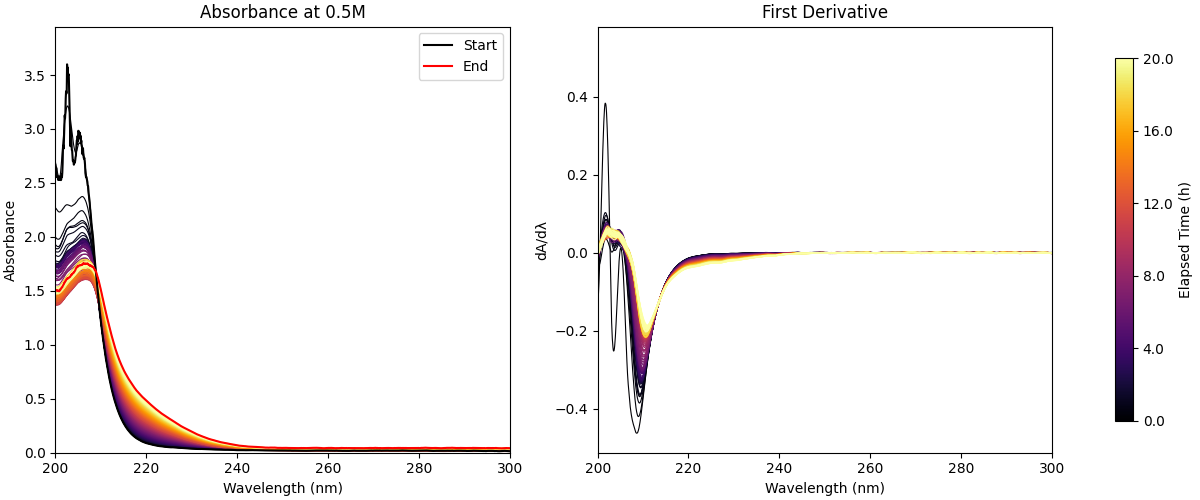

Extinction coefficient at 215 nm: 0.5250630092162083


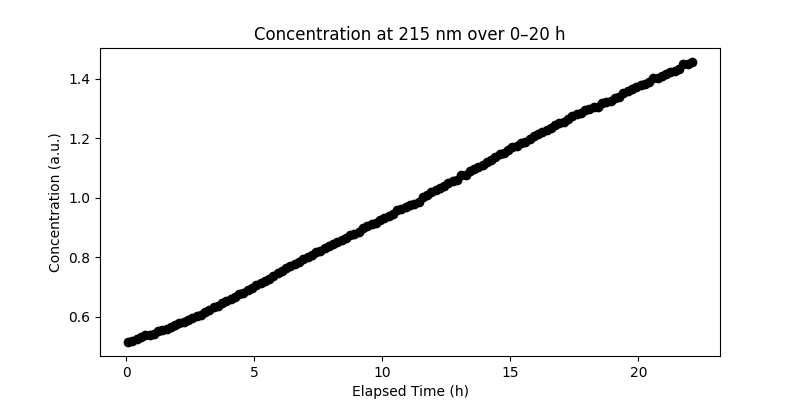

In [13]:
skip = 40
exp_folder = './D2_lamp_results/20250702_urea_0.5M'
norm_idx = 320
starting_hour = 12 # start hour of experiment

def extract_elapsed_seconds(filename):
    """
    Convert timestamp in filename to seconds elapsed since starting_hour,
    wrapping past midnight as needed.
    """
    time_str = os.path.basename(filename).split('_')[-1].replace('.txt', '')
    h, m, s, ms = map(int, time_str.split('-'))
    total_sec = h * 3600 + m * 60 + s + ms / 1000.0
    offset_sec = starting_hour * 3600
    elapsed = total_sec - offset_sec
    if elapsed < 0:
        # crossed midnight
        elapsed += 24 * 3600
    return elapsed

# Gather and sort experiment files (exclude background/reference/standard)
all_txt = glob.glob(os.path.join(exp_folder, '*.txt'))
exp_files = [f for f in all_txt if all(tag not in f for tag in ('background', 'reference', 'standard'))]
exp_files.sort(key=lambda f: extract_elapsed_seconds(f))

# Compute elapsed times in seconds and hours
elapsed_sec = [extract_elapsed_seconds(f) for f in exp_files]
elapsed_hr = [t / 3600.0 for t in elapsed_sec]

# Colormap from 0 to 20 hours
cmap = colormaps['inferno']
norm = Normalize(vmin=0, vmax=20)

# Load background and reference
I_background = I_ref = None
for file in all_txt:
    if 'background' in file:
        x, I_background = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
        print('Loaded background:', file)
    elif 'reference' in file:
        x, I_ref = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
        print('Loaded reference:', file)

# Prepare absorbance traces
abs_traces = []
for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_traces.append(abs_trace)

# --- Plot absorbance and its derivative ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, constrained_layout=True)

for abs_trace, t_hr in zip(abs_traces, elapsed_hr):
    # smoothing
    window_length = min(51, len(abs_trace) // 2 * 2 + 1)
    abs_smooth = savgol_filter(abs_trace, window_length=window_length, polyorder=3)
    dA = np.gradient(abs_smooth, x)
    dA_smooth = savgol_filter(dA, window_length=window_length, polyorder=3)

    color = cmap(norm(t_hr))
    ax1.plot(x, abs_smooth, color=color, lw=0.8)
    ax2.plot(x, dA_smooth, color=color, lw=0.8)

# Sanity-check start/end spectra
# start
start_file = exp_files[0]
x, I0 = np.loadtxt(start_file, skiprows=skip, usecols=(0, 1), unpack=True)
abs0 = -np.log10((I0 - I_background) / (I_ref - I_background))
ax1.plot(x, abs0, 'k-', label='Start')
# end
end_file = exp_files[-1]
x, Iend = np.loadtxt(end_file, skiprows=skip, usecols=(0, 1), unpack=True)
absE = -np.log10((Iend - I_background) / (I_ref - I_background))
ax1.plot(x, absE, 'r-', label='End')
ax1.legend()

# Colorbar from 0 to 20 hrs
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='vertical', location='right', shrink=0.85)
cbar.set_label('Elapsed Time (h)')
ticks = np.linspace(0, 20, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.1f}" for t in ticks])

# Labels and limits
ax1.set_xlim(200, 300)
ax1.set_ylim(0)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Absorbance')
ax1.set_title('Absorbance at 0.5M')

ax2.set_xlim(200, 300)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('dA/dλ')
ax2.set_title('First Derivative')

plt.show()

# --- Concentration vs Time ---
ext_data = pd.read_csv('./extinction_coeff_calibration_2.csv')
interp = interp1d(ext_data['Wavelength (nm)'], ext_data['Extinction coefficient'],
                  kind='linear', fill_value='extrapolate')
target_wavelength = 215
epsilon = float(interp(target_wavelength))
pathlength = 1.0  # cm
print(f'Extinction coefficient at {target_wavelength} nm: {epsilon}')

# index for target wavelength
idx = (np.abs(x - target_wavelength)).argmin()
concentrations = [trace[idx] / (epsilon * pathlength) for trace in abs_traces]

plt.figure(figsize=(8, 4))
plt.plot(elapsed_hr, concentrations, 'o', lw=1, color='black')
plt.xlabel('Elapsed Time (h)')
plt.ylabel('Concentration (a.u.)')
plt.title(f'Concentration at {target_wavelength} nm over 0–20 h')
plt.show()

### 1.0 M concentration

## Change in absorbance for the initial 10 min

C:\Users\vikki\AppData\Local\Temp\ipykernel_50172\3864477309.py:45: RuntimeWarning: divide by zero encountered in log10
  abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
C:\Users\vikki\AppData\Local\Temp\ipykernel_50172\3864477309.py:45: RuntimeWarning: invalid value encountered in log10
  abs_trace = -np.log10((I - I_background) / (I_ref - I_background))


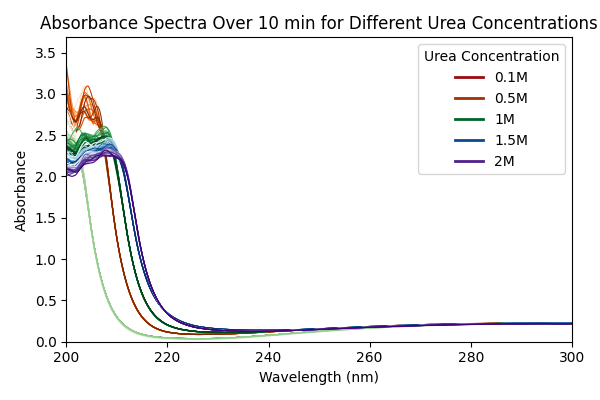

In [16]:

skip = 40
exp_folder = './D2_lamp_results/20250704_urea_initial_check'
concentrations = ['0.1M', '0.5M', '1M', '1.5M', '2M']
colormaps_list = ['Reds', 'Oranges', 'Greens', 'Blues', 'Purples']  # One per concentration

def extract_time_seconds(filename):
    time_str = filename.split('_')[-1].replace('.txt', '')
    h, m, s, ms = map(int, time_str.split('-'))
    return h * 3600 + m * 60 + s + ms / 1000.0

# Find all experiment files
all_files = glob.glob(f'{exp_folder}/**/*.txt', recursive=True)

# Group files by concentration
files_by_conc = {conc: [] for conc in concentrations}
for file in all_files:
    for conc in concentrations:
        if conc in file and 'reference' not in file and 'background' not in file and 'standard' not in file:
            files_by_conc[conc].append(file)

# Load reference and background (assuming only one shared set)
I_background = I_ref = None
for file in all_files:
    if 'background' in file:
        x, I_background = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    elif 'reference' in file:
        x, I_ref = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

# Process each concentration group
for conc, cmap_name in zip(concentrations, colormaps_list):
    files = sorted(files_by_conc[conc], key=lambda f: extract_time_seconds(os.path.basename(f)))
    
    if len(files) == 0:
        continue  # Skip if no files for this concentration
    
    times = [extract_time_seconds(os.path.basename(f)) for f in files]
    cmap = colormaps[cmap_name]
    norm = Normalize(vmin=min(times), vmax=max(times))

    for file, t in zip(files, times):
        x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
        abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
        abs_smooth = savgol_filter(abs_trace, window_length=min(51, len(abs_trace) // 2 * 2 + 1), polyorder=3)
        ax.plot(x, abs_smooth, color=cmap(norm(t)), lw=0.8)

# Axis formatting
ax.set_xlim(200, 300)
ax.set_ylim(0, None)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance')
ax.set_title('Absorbance Spectra Over 10 min for Different Urea Concentrations')

# Legend color guide (optional)
from matplotlib.lines import Line2D
legend_lines = [Line2D([0], [0], color=colormaps[cm](0.9), lw=2) for cm in colormaps_list]
ax.legend(legend_lines, concentrations, title="Urea Concentration")

plt.tight_layout()
plt.show()
